In [1]:
#Imports and everything else, better to not modify this part
import numpy as np
import sys
import pandas as pd
import math
#
import matplotlib.pyplot as plt

import matplotlib.ticker as ticker
# from collections import namedtuple

try:
    # for Python2
    from Tkinter import *   ## notice capitalized T in Tkinter 
except ImportError:
    # for Python3
    from tkinter import *   ## notice lowercase 't' in tkinter here
    
    
    pd.set_option('display.max_rows', 100)


In [2]:
#Import gossip log and filter the messages received on grpc

fileHandle = open('/home/flav/gossip/gossip_data/data/lotus/unl/log_stdout.out', "r", encoding="latin1")
lines = fileHandle.readlines()

with open('/home/flav/gossip/gossip_data/filter/unl.out', 'w+') as f:
    for line in lines:
      if '| gRPC-Server | received |' in line:
        print(line, file=f)
fileHandle.close()

In [3]:
# Create dataset for the gossip and correct the datetime
data = pd.read_csv('/home/flav/gossip/gossip_data/filter/unl.out', sep="|", header=None, error_bad_lines=False, warn_bad_lines=False, usecols=[0,6,7])
df = pd.DataFrame(data)

#Rename
df = df.rename(index=str, columns={0: "DateTime", 7: "ValidatorKey", 6: "Hash"})
# df.style

# Limit time, because the others ran for only a couple of hours
# # print(df.loc["DateTime" == "21397072576816640211201_195113"])
# # df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce', format="%Y%m%d_%H%M%S")
# df = df.loc[df["DateTime"] > "2022/04/11 01:00:00"]
# df = df.loc[df["DateTime"] < "2022/04/11 03:00:00"]
# df = df[df["DateTime"].isin(pd.date_range("2021-12-01 19:25:00", "2021-12-01 20:28:00"))]

df.head(5)

,DateTime,Hash,ValidatorKey
0,2022-06-13_13:06:02.515,1216302c0156bc82813c4dbbcfa243cff3bb5a3869d90...,n9MM8mPsGPRybet6myp7cmtaxGyHjvbi3SzL88RHko2z9...
1,2022-06-13_13:06:02.529,688d8cf22811c7c37a6e69670c4054aaca7c6d43b0631...,n9MKE9H9ejjhPVqgHgw6hM8k7oujASsAGpPYwwfRuo4Fs...
2,2022-06-13_13:06:02.540,8bd968550c2cdd64a621338b1141f3f79800a3ce11a8c...,n9KwuSzpE81ri7uFkBp7tWaf1c6xb4FB56Ybkmjvyevsh...
3,2022-06-13_13:06:02.567,067904f401450fbf0a245f3ec3474b1146e182148d7b8...,n9MwYRH3Pvt4ATQSsgokJX21NWkMt1RcxcU6aaMMFt6mC...
4,2022-06-13_13:06:02.583,98408d7fe3599b6ff10850481c365460686bc38f9d3ff...,n9JY6PGHNLxS7KgBKHrNmWpqULjcKTV4HunyHh5VCnzwT...


In [4]:
#Aggregate by hash and count
# dfQuantile1 = df.groupby(['grp', 'metric', 'method', 'region', 'selectivity']).quantile(q=0.25, axis=0, numeric_only=True, interpolation='linear').reset_index()
# dfQuantile1 = dfQuantile1.rename(index=str, columns={"value": "first"})

dups = df.drop(columns=["DateTime","ValidatorKey"])
dups = dups.groupby(dups.columns.tolist()).size().reset_index().rename(columns={0:'dups'}).sort_values(by=["dups"], ascending=False)

dups.head(5)
dupsSave=dups.loc[dups["dups"] < 25]
dupsSave.to_csv('/home/flav/gossip/gossip_data/dupsUNL.csv')

In [5]:
hashLoc = dups.loc[dups['dups'] == 4]['Hash'].values[0]
mostDups = df.loc[df['Hash'] == hashLoc]

mostDups.head(5)
# mostDups.style
#868cd166b1a4c1dd879bb5f0a2d1c1de213d9b3eafe95
#3986ab419e31f171abae9d5ca2fcfda199bfef896362e

,DateTime,Hash,ValidatorKey
8255,2022-06-13_13:44:27.027,29a984dbae90840f1a30e600f5b33168f6cf0d63fe26b...,n9MwYRH3Pvt4ATQSsgokJX21NWkMt1RcxcU6aaMMFt6mC...
8335,2022-06-13_13:44:51.168,29a984dbae90840f1a30e600f5b33168f6cf0d63fe26b...,n9MwYRH3Pvt4ATQSsgokJX21NWkMt1RcxcU6aaMMFt6mC...
8455,2022-06-13_13:45:27.259,29a984dbae90840f1a30e600f5b33168f6cf0d63fe26b...,n9MwYRH3Pvt4ATQSsgokJX21NWkMt1RcxcU6aaMMFt6mC...
8545,2022-06-13_13:45:54.317,29a984dbae90840f1a30e600f5b33168f6cf0d63fe26b...,n9MwYRH3Pvt4ATQSsgokJX21NWkMt1RcxcU6aaMMFt6mC...


In [6]:
#The number of messages sent x times
dist = dups.drop(columns=["Hash"])

dist = dist.groupby(dist.columns.tolist()).size().reset_index().rename(columns={0:'distribution'}).sort_values(by=["distribution"], ascending=False)

dist.head(5)

,dups,distribution
0,1,1619
1,2,526
2,3,284
3,4,218
4,5,146


In [7]:
#Percentage of duplicates
# dist2 = dist[loc[dups]]
totalMessages = dist["distribution"].sum()
perc = dist

perc["percentage"] = (perc["distribution"]*100)/totalMessages
perc = perc.sort_values(by="distribution", ascending=False)

#Remove outliers... everyone that is lower than 0.014%
percHist = perc.loc[perc["dups"] < 25].drop(columns=["distribution"])
# percHist.to_csv('/home/flav/gossip/gossip_data/dupsUNL.csv')
percHist.head(100)

,dups,percentage
0,1,46.416284
1,2,15.080275
2,3,8.142202
3,4,6.250000
4,5,4.185780
5,6,3.325688
6,7,2.379587
7,8,1.806193
10,11,1.634174
8,9,1.519495


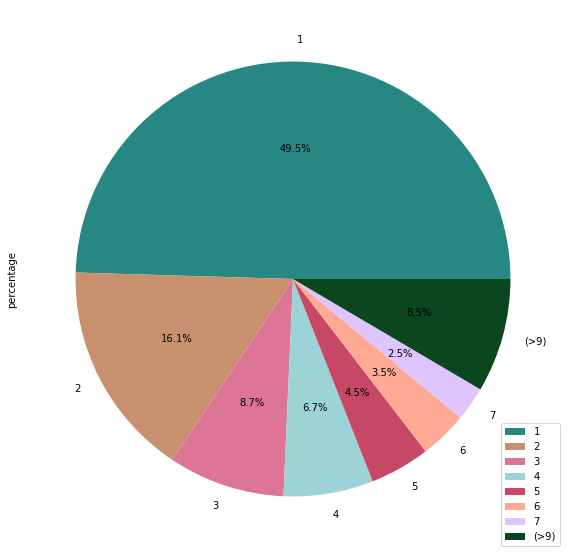

In [8]:
#Plot percentage

#If the percenatge is under 1%, put on the category "other"
percPlot = perc.loc[perc["percentage"] > 2].drop(columns=["distribution"])

# % under 1%
percOther = perc["percentage"].loc[perc["percentage"] <= 1].sum()
# generate row to append
percOtherRow = pd.DataFrame([["(>9)", percOther]], columns=["dups", "percentage"])

percPlot=percPlot.append(percOtherRow, ignore_index=True)
# percPlot = percPlot.reindex(percPlot["dups"])

#set colors, cause they are repeting when on automatic
colors = ['#278782', '#c9906d', '#DD7596', '#9cd3d6', '#c74767', '#fea993', '#dfc5fe', '#0a461e', '#01889f', '#2bb179', '#B7C3F3', 'pink'] 

percPlot.style
percPlotPie = percPlot.plot(kind="pie", y="percentage", figsize=(10,10), autopct="%1.1f%%", labels=percPlot["dups"], colors=colors)

fig = percPlotPie.get_figure()
# fig.savefig("percentageDupsGeneral.png")

In [9]:
sumMessages = dups['dups'].sum()

print(sumMessages)


13847


[Text(0, 0.5, 'Frequency'), Text(0.5, 1.0, 'Frequency Histogram')]

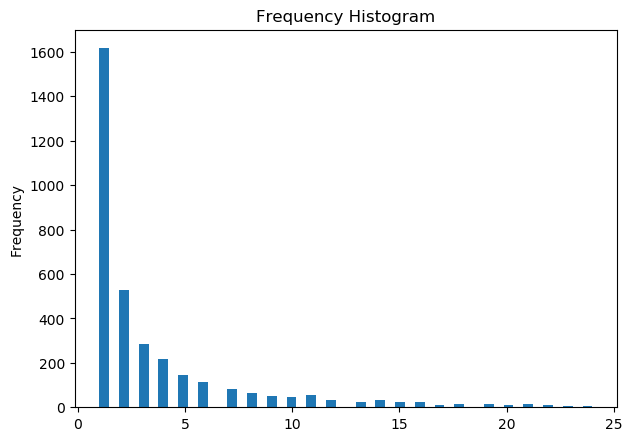

In [10]:
#Histogram
hist = dups['dups'].loc[dups['dups'] < 25]
# dupsNorm.head(5)

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.hist(hist, bins=50)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency')